<a href="https://colab.research.google.com/github/vedantdave77/project.Orca/blob/master/ML%20deployment-%20AWS.SageMaker/Boston_House(AWS_SageMaker_Custom_Deployment).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AWS SAGEMAKER 
Hello, I am [Vedant_Dave](https://vedantdave77.github.io), an inspired Machine Learning Practitioner.  

## Intro To Topic
Today, I am going to deploy Boston Housing data Project using AWS Sagemaker's High level API called - "Python SDK". 
> This API has facility to train and deploy model in cloud directly from innner Jupyter notebook creation. So, I will use simple Machine learning workflow as usaual. 

> Data loading --> Data Preparation --> Model Training --> HP Tuning --> Deployment in AWS. (Hopefully, try to make Web Application). 

---
---

First of all, I will use SageMaker's batch transform feature, which  is a high-performance and high-throughput method for transforming data and generating inferences. 

- I personally think, It's ideal for scenarios where you're dealing with large batches of data, don't need sub-second latency, or need to both preprocess and transform the training data. 

- My main focus is to deploy model, so on analytic point of view, I tried to use Sagemaker's ML library and find median housing price for specific housing requrements in certain areas. 

 


## Set Environment (lib & SageMaker)

In [1]:
# Setting-up Notebook in relevant environment.

import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_boston
import sklearn.model_selection

In [2]:
# set sagemaker in env.
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# Object to represent current active session of sagemaker - contains some useful info. for future usage.
session = sagemaker.Session()

# object shows IAM role - will help us to assign training job to sagemaker.
role = get_execution_role()

## Download Data 

In [3]:
# download data from sagemaker collection 
boston = load_boston()


## Data preparation and splitting.


In [10]:
# prepare data for python notebook
X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
y_bos_pd = pd.DataFrame(boston.target)

# splitting into train and test
X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X_bos_pd, y_bos_pd, test_size =0.33)

# further splitting of train to train(2/3) and validation(1/3)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.33)

## Uploading data files to S3.

Keep in mind that, 

- When a training job is constructed using SageMaker, a container is executed which performs the training operation.
- This container is given access to data that is stored in S3. This means that we need to upload the data we want to use for training to S3. 
- In addition, when we perform a batch transform job, SageMaker expects the input data to be stored on S3. We can use the SageMaker API to do this and hide some of the details, but first data saved locally and then uploaded to S3 container.




In [11]:
# define & ensure data dictionary...
data_dir = '.../data/boston'
if not os.path.exists(data_dir):
  os.makedirs(data_dir)

In [13]:
# In data_dir, I amd creating csv file format for all data, and in validation and train set target data comes in first columns.

X_test.to_csv(os.path.join(data_dir,'test.csv'),header = False, index = False)
 
pd.concat([y_val,X_val], axis =1).to_csv(os.path.join(data_dir, 'validation.csv'),header=False, index= False)
pd.concat([y_train,X_train],axis =1).to_csv(os.path.join(data_dir,'train.csv'),header=False,index=False)

### Upload to S3 - data storage.
Its good prectice to give prefix to your S3 bucket, so you can easily get idea about specific container for relevant project. 
- Here, I am giving name as "dataset_name-algorithm_name-API_level".

I will use xgboost algorithm, which is one of the modern approach for supervised learning. It boost our algorithm gradient and give high accuracy result with good F1 score Matrix. 

> For more info, visit [XGBoost](https://xgboost.readthedocs.io/en/latest/) official documentation.

In [14]:
prefix = 'boston-xgboost-HL'

test_location = session.upload_data(os.path.join(data_dir,'test.csv'),key_prefix = prefix)
val_location = session.upload_data(os.path.join(data_dir,'validation.csv'), key_prefix = prefix)
train_location = session.upload_data(os.path.join(data_dir,'train.csv'),key_prefix = prefix)

'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.
'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.
'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.


## Train and construct the XGBoost Model

### setup the training job

For setup training job I need to know the exact information about my sagemaker, s3 container and other general information regarding instance. 

- I am using this [API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateTrainingJob.html) provided by sagemaker for reference to create this training job.


In [15]:
# We will need to know the name of the container that we want to use for training. SageMaker provides  a nice utility method to construct this for us.
container = get_image_uri(session.boto_region_name, 'xgboost')

# specify parameters for tranining job
training_params = {}

# specify training role (IAM) of this session [same as sagemaker role]
training_params['RoleArn'] = role

# specify training algorithm and container for job
training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

# specify output (model artifacts-model change) space [in s3]
training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + session.default_bucket() + "/" + prefix + "/output"
}

# specify computer capability provided to instance and stopping condition in case or error.
training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {                                         # Error condition stopping
    "MaxRuntimeInSeconds": 86400
}

# XGBoost model hyper parameters.
training_params['HyperParameters'] = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.8",
    "objective": "reg:linear",
    "early_stopping_rounds": "10",
    "num_round": "200"
}

# define the data path (from where and what kind of data sagemaker will retrive)
training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",                                                 # which data 
        "DataSource": {            
            "S3DataSource": {
                "S3DataType": "S3Prefix",                                       # data identification
                "S3Uri": train_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",                                                   # what kind of data 
        "CompressionType": "None"                                               # large data may be compressed
    },
    {
        "ChannelName": "validation",                                            # same as above for validation
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": val_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    }
]

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
	get_image_uri(region, 'xgboost', '1.0-1').


### Execute the training job 
Give command to execute after knowing above data.



In [18]:
import time
from time import gmtime, strftime

In [19]:
training_job_name = "boston-xgboost-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
training_params['TrainingJobName'] = training_job_name

# And now we ask SageMaker to create (and execute) the training job
training_job = session.sagemaker_client.create_training_job(**training_params)

In [20]:
# Its lengthy job so we need to wait until gettingthe anwer.
session.logs_for_job(training_job_name, wait=True)

2020-06-06 19:55:28 Starting - Starting the training job...
2020-06-06 19:55:30 Starting - Launching requested ML instances......
2020-06-06 19:56:37 Starting - Preparing the instances for training......
2020-06-06 19:57:38 Downloading - Downloading input data...
2020-06-06 19:58:13 Training - Downloading the training image.Arguments: train
[2020-06-06:19:58:34:INFO] Running standalone xgboost training.
[2020-06-06:19:58:34:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8500.59mb
[2020-06-06:19:58:34:INFO] Determined delimiter of CSV input is ','
[19:58:34] S3DistributionType set as FullyReplicated
[19:58:34] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-06-06:19:58:34:INFO] Determined delimiter of CSV input is ','
[19:58:34] S3DistributionType set as FullyReplicated
[19:58:34] 112x13 matrix with 1456 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=

### Build the model
The above job give us lot of information and its hard to understand according to data structure so its better to understand it from sagemaaker ownself. 

- Then we will make model (not a ml model but model for sagemaker information collection.

In [23]:
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)

model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

In [24]:
# give model a unique name by (training job name - mode - so, helpful to distinguish each and every job seperately)
model_name = training_job_name + "-model"

# specify information for sagemaker to understand which container need to use for interference and wher it is situated.
primary_container = {
    "Image": container,
    "ModelDataUrl": model_artifacts
}

# And lastly we construct the SageMaker model
model_info = session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)

### Testing the Model.

We already have trained model now and validation also do its best job to make model more generalize and model will not overfit. 

Here, as other notebooks I will not go for testing and the reason is simple that, here I am going to deploy a model and get the endpoint for deployment and get testing from that points so, all the work for deployment starts here and code chaged..

### Deploy Model by creating endpoint.

Now, let's create endpiont which will work as a link between sagemaker and web application.

In [25]:
# endpoint creation and naming
endpoint_config_name = "boston-xgboost-endpoint-config-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# confugure endpoint with type of instance, no. of instance run and model name
endpoint_config_info = session.sagemaker_client.create_endpoint_config(
                            EndpointConfigName = endpoint_config_name,
                            ProductionVariants = [{
                                "InstanceType": "ml.m4.xlarge",
                                "InitialVariantWeight": 1,
                                "InitialInstanceCount": 1,
                                "ModelName": model_name,
                                "VariantName": "AllTraffic"
                            }])

In [28]:
# Again, we need a unique name for our endpoint
endpoint_name = "boston-xgboost-endpoint-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# And then we can deploy our endpoint
endpoint_info = session.sagemaker_client.create_endpoint(
                    EndpointName = endpoint_name,
                    EndpointConfigName =endpoint_config_name)

In [29]:
# wait for endpoint to shut it down
endpoint_dec = session.wait_for_endpoint(endpoint_name)

---------------!

### Model use and Result visuzlization
Now  Analyze the result by comaring them.

In [32]:
# First we need to serialize the input data. In this case we want to send the test data as a csv and
# so we manually do this. Of course, there are many other ways to do this.
payload = [[str(entry) for entry in row] for row in X_test.values]
payload = '\n'.join([','.join(row) for row in payload])

In [34]:
# use sagemaker runtime client rather than sagemaker client. so we can invoke the endpoint for use
response = session.sagemaker_runtime_client.invoke_endpoint(
                                                EndpointName = endpoint_name,
                                                ContentType = 'text/csv',
                                                Body = payload)
    
result = response['Body'].read().decode('utf8')

Text(0.5, 1.0, 'Median Price vs Predicted Price')

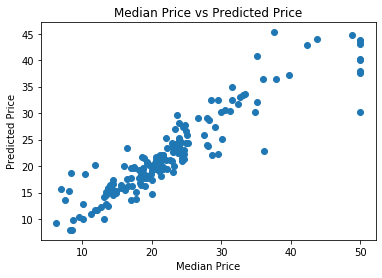

In [36]:
# predict data visualization/
y_pred = np.fromstring(result, sep=',')
plt.scatter(y_test, y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

### Delete endpoint.
Here, its better to delete endpoint to shut it down. because if not then AWS will continuously run it and pay the lenght of time, you use endpoint for deployment.

In [37]:
session.sagemaker_client.delete_endpoint(EndpointName = endpoint_name)

{'ResponseMetadata': {'RequestId': '027b1f05-554f-410a-bb79-0e399e1da3cd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '027b1f05-554f-410a-bb79-0e399e1da3cd',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 06 Jun 2020 20:27:24 GMT'},
  'RetryAttempts': 0}}

### Clean up the disk and directory 
Sometime, when we use deep network then disk will be full and give error for the next operation. Which shold be hard to diagnosed. So, better to clean up the space.

In [38]:
# remove all of the files contained in the data_dir directory
!rm $data_dir/*

# delete the directory itself
!rmdir $data_dir

In [39]:
# "Keep Learning, Enjoy Empowering" @dave117